In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import sklearn as sk
import os
from skimage.util import random_noise
import matplotlib.pyplot as plt
from yellowbrick.base import Visualizer
from yellowbrick.cluster import KElbowVisualizer
from PIL import Image, UnidentifiedImageError
from sklearn.cluster import KMeans
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def preprocessDataSet(dataset):
    dataset = dataset.astype("float32") / 255.0
    return dataset

def createNoiseData(dataset):
    dataset_noise = random_noise(dataset, seed=32)
    return dataset_noise

def readDataSet(input_path="", use_available_dataset=False, val_factor=0.2):
    if use_available_dataset == True:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
        x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
        raw_data = np.concatenate((x_train, x_test), axis=0)
        ground_truth = np.concatenate((y_train, y_test), axis=0)
    else:
        if os.path.exists(input_path) == False:
            print("Cannot find path.")
            return
        for root, _, files in os.walk(input_path):
            for name in files:
                path = os.path.join(root, name)
                try:
                    Image.open(path)
                except UnidentifiedImageError:
                    print("Corrupt image found in " + path + " , removing...")
                    os.remove(path)
                except:
                    print("Removing non-image file at " + path)
                    os.remove(path)
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            input_path,
            label_mode="int",
            image_size=(28, 28),
            seed=32
        )
        pre_data = np.array(list(dataset.unbatch()))
        _, columns = np.shape(pre_data)
        (raw_data, ground_truth) = (pre_data[:, 0:columns-1], pre_data[:, columns-1:columns])
        val_size = int(len(raw_data) * (1 - val_factor))
        (x_train, x_test) = (raw_data[0:val_size], raw_data[val_size:len(raw_data)])
    return (raw_data, ground_truth), (x_train, x_test)

def buildAndTrainModel(x_train, x_test, denoising=False):
    (x_train, x_test) = (preprocessDataSet(x_train), preprocessDataSet(x_test))
    
    _, _, _, channel_size = np.shape(x_train)
    input_layer = tf.keras.Input((28, 28, channel_size))
    conv1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(input_layer)
    pool1 = tf.keras.layers.MaxPooling2D(padding="same")(conv1)
    conv2 = tf.keras.layers.Conv2D(64, 5, padding="same", activation="relu")(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(padding="same")(conv2)
    conv3 = tf.keras.layers.Conv2D(128, 7, padding="same", activation="relu")(pool2)
    pool3 = tf.keras.layers.MaxPooling2D((7, 7), padding="same")(conv3)
    flat_layer = tf.keras.layers.Flatten()(pool3)
    dense_layer = tf.keras.layers.Dense(10)(flat_layer)

    encoder = tf.keras.Model(input_layer, dense_layer, name="encoder")

    decode_layer = tf.keras.layers.Dense((1 * 1 * 128), activation="relu")(dense_layer)
    reshape_layer = tf.keras.layers.Reshape((1, 1, 128))(decode_layer)
    convt1 = tf.keras.layers.Conv2DTranspose(128, 7, strides=7, activation="relu")(reshape_layer)
    convt2 = tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding="same", activation="relu")(convt1)
    convt3 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(convt2)
    decoded = tf.keras.layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(convt3)

    autoencoder = tf.keras.Model(input_layer, decoded, name="autoencoder")
    autoencoder.summary()

    autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    es = EarlyStopping(monitor="loss", mode="min")
    if denoising == True:
        (x_train_noise, x_test_noise) = (createNoiseData(x_train), createNoiseData(x_test))
        autoencoder.fit(x_train_noise, x_train, epochs=100, validation_data=(x_test_noise, x_test), callbacks=[es])
        return autoencoder
    autoencoder.fit(x_train, x_train, epochs=100, validation_data=(x_test, x_test), callbacks=[es])
    return encoder

def visualizeDataKMeans(encoder, raw_data):
    reduced_features= sk.manifold.TSNE().fit_transform(encoder.predict(raw_data))
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2, 30))
    visualizer.fit(reduced_features)
    labels = KMeans(n_clusters=visualizer.elbow_value_).fit_predict(reduced_features)

    fig = plt.figure(figsize=(20.0, 20.0), dpi=80)
    ax = fig.add_subplot(111)
    scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, s=50, cmap="jet")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(scatter)
    plt.show()
    return labels, reduced_features

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         401536    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 128)         

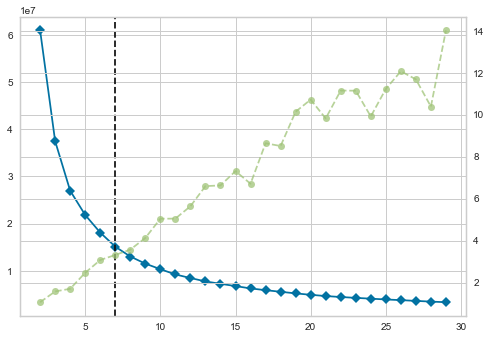

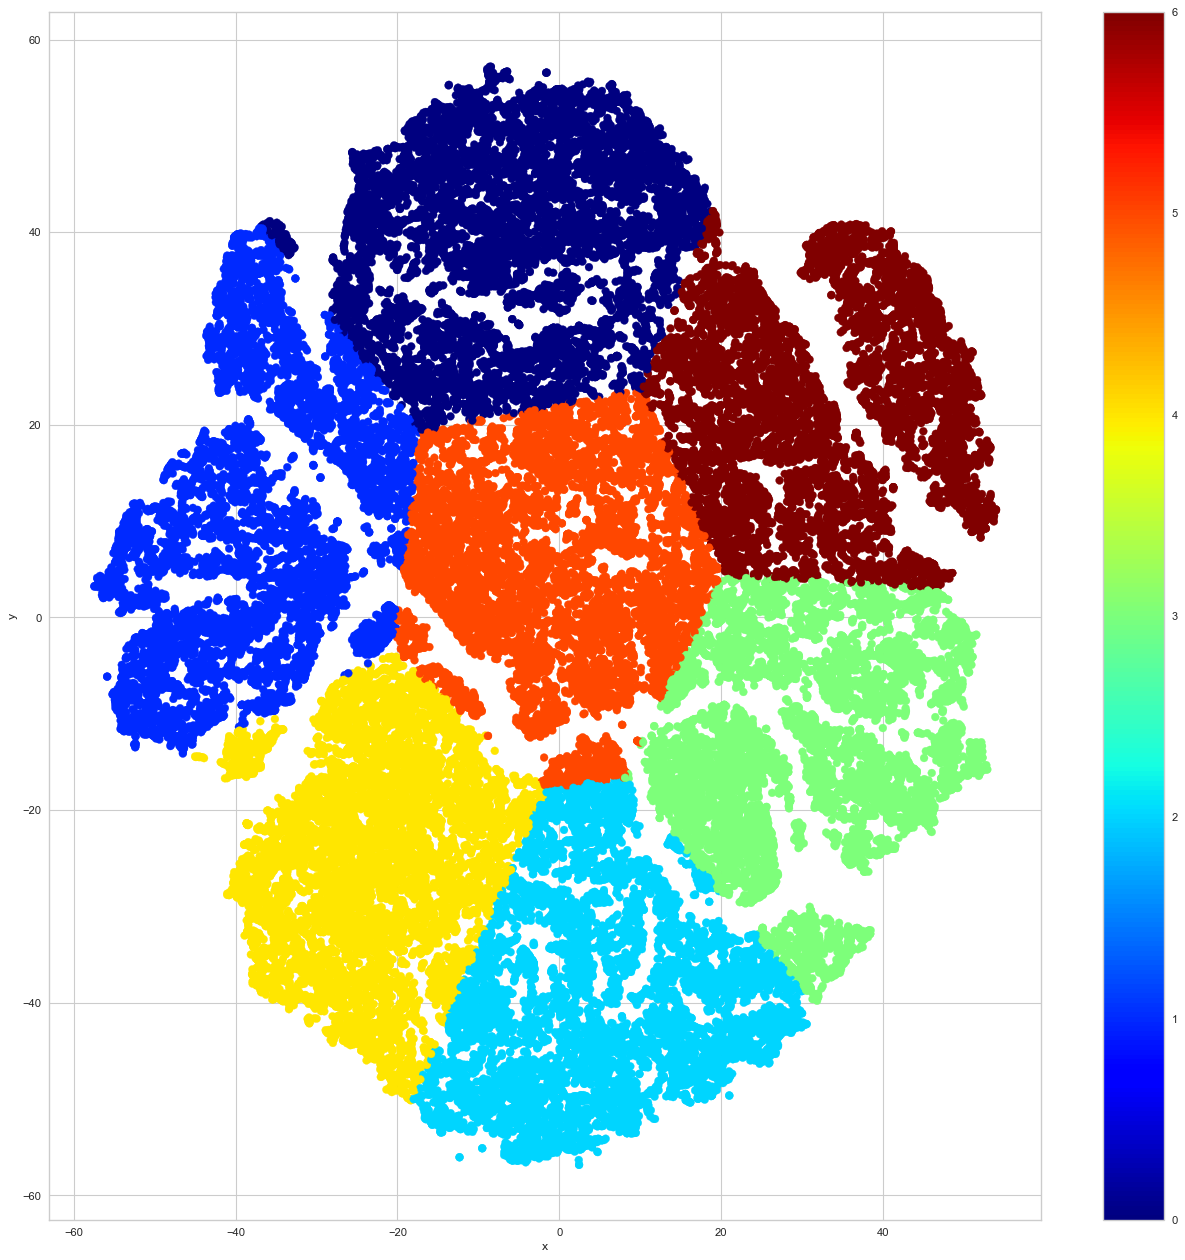

In [4]:
(raw_data, ground_truth), (x_train, x_test) = readDataSet(use_available_dataset=True)
encoder = buildAndTrainModel(x_train, x_test)
(labels, reduced_features) = visualizeDataKMeans(encoder, raw_data)

In [5]:
from sklearn.metrics import completeness_score

with open("results/fashion_kmeans.txt", "w") as f:
    f.write(str(completeness_score(ground_truth, labels)))

In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

def plotEpsDBSCAN(reduced_features):
    neigh = NearestNeighbors(n_neighbors=4)
    nbrs = neigh.fit(reduced_features)
    distances, indices = nbrs.kneighbors(reduced_features)

    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)
    return reduced_features

def visualizeDataDBSCAN(reduced_features, eps):
    labels = DBSCAN(eps=eps, min_samples=4).fit_predict(reduced_features)
    
    fig = plt.figure(figsize=(20.0, 20.0), dpi=80)
    ax = fig.add_subplot(111)
    scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, s=50, cmap="jet")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(scatter)
    plt.show()
    return labels

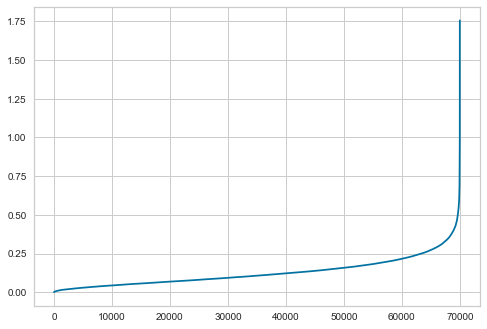

In [7]:
reduced_features = plotEpsDBSCAN(reduced_features)

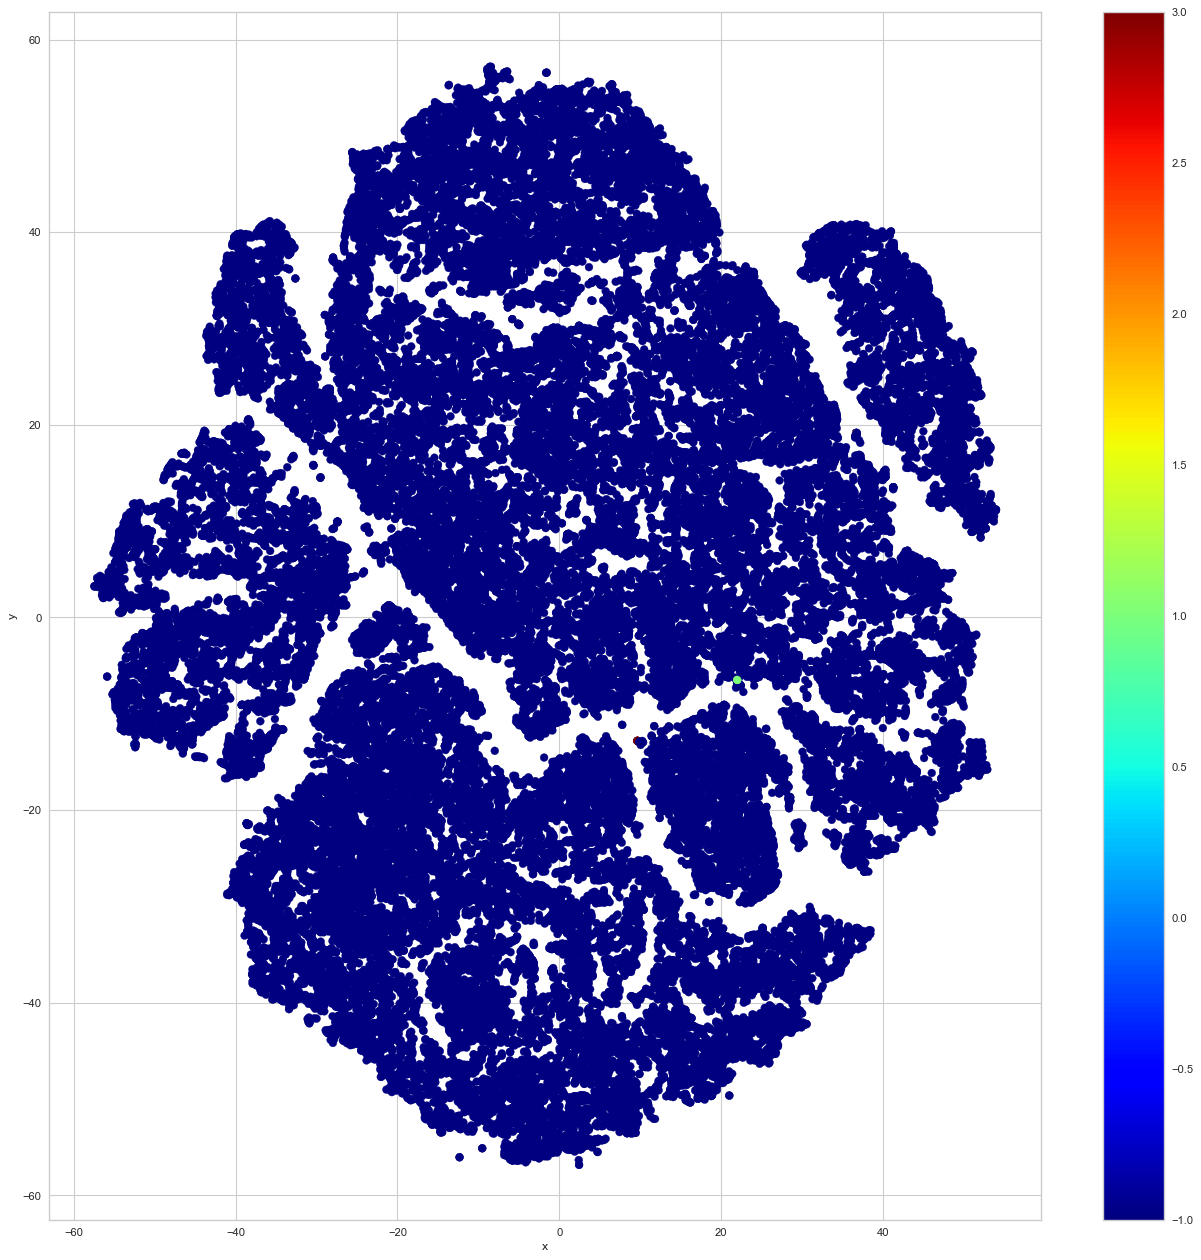

In [8]:
labels = visualizeDataDBSCAN(reduced_features, 0.01)

In [9]:
with open("results/fashion_dbscan.txt", "w") as f:
    f.write(str(completeness_score(ground_truth, labels)))

In [10]:
print(len(np.unique(labels)))

5
